# Air pollution GRU and LSTM model

In [1]:
import pandas as pd
import numpy as np
# PyTorch
import torch
import torch.nn as nn
import lightning as L
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
# Ray
from ray.train.lightning import (
    RayDDPStrategy,
    RayLightningEnvironment,
    RayTrainReportCallback,
    prepare_trainer,
)
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.train import RunConfig, ScalingConfig, CheckpointConfig
from ray.train.torch import TorchTrainer
# Sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
# Visualization
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates
from datetime import datetime

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Exploring the dataset

In [3]:
pollution_df  = pd.read_csv("data/LSTM-Multivariate_pollution.csv")

In [81]:
pollution_df.head()

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [82]:
pollution_df.shape

(43800, 9)

In [83]:
pollution_df.dtypes

date          object
pollution    float64
dew            int64
temp         float64
press        float64
wnd_dir       object
wnd_spd      float64
snow           int64
rain           int64
dtype: object

In [84]:
pollution_df.describe()

,pollution,dew,temp,press,wnd_spd,snow,rain
count,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,94.013516,1.828516,12.459041,1016.447306,23.894307,0.052763,0.195023
std,92.252276,14.429326,12.193384,10.271411,50.022729,0.760582,1.416247
min,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,24.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,68.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,132.250000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


In [85]:
pollution_df.wnd_dir.unique()

array(['SE', 'cv', 'NW', 'NE'], dtype=object)

In [27]:
pollution_df.isna().sum()

date         0
pollution    0
dew          0
temp         0
press        0
wnd_dir      0
wnd_spd      0
snow         0
rain         0
dtype: int64

## Visualization

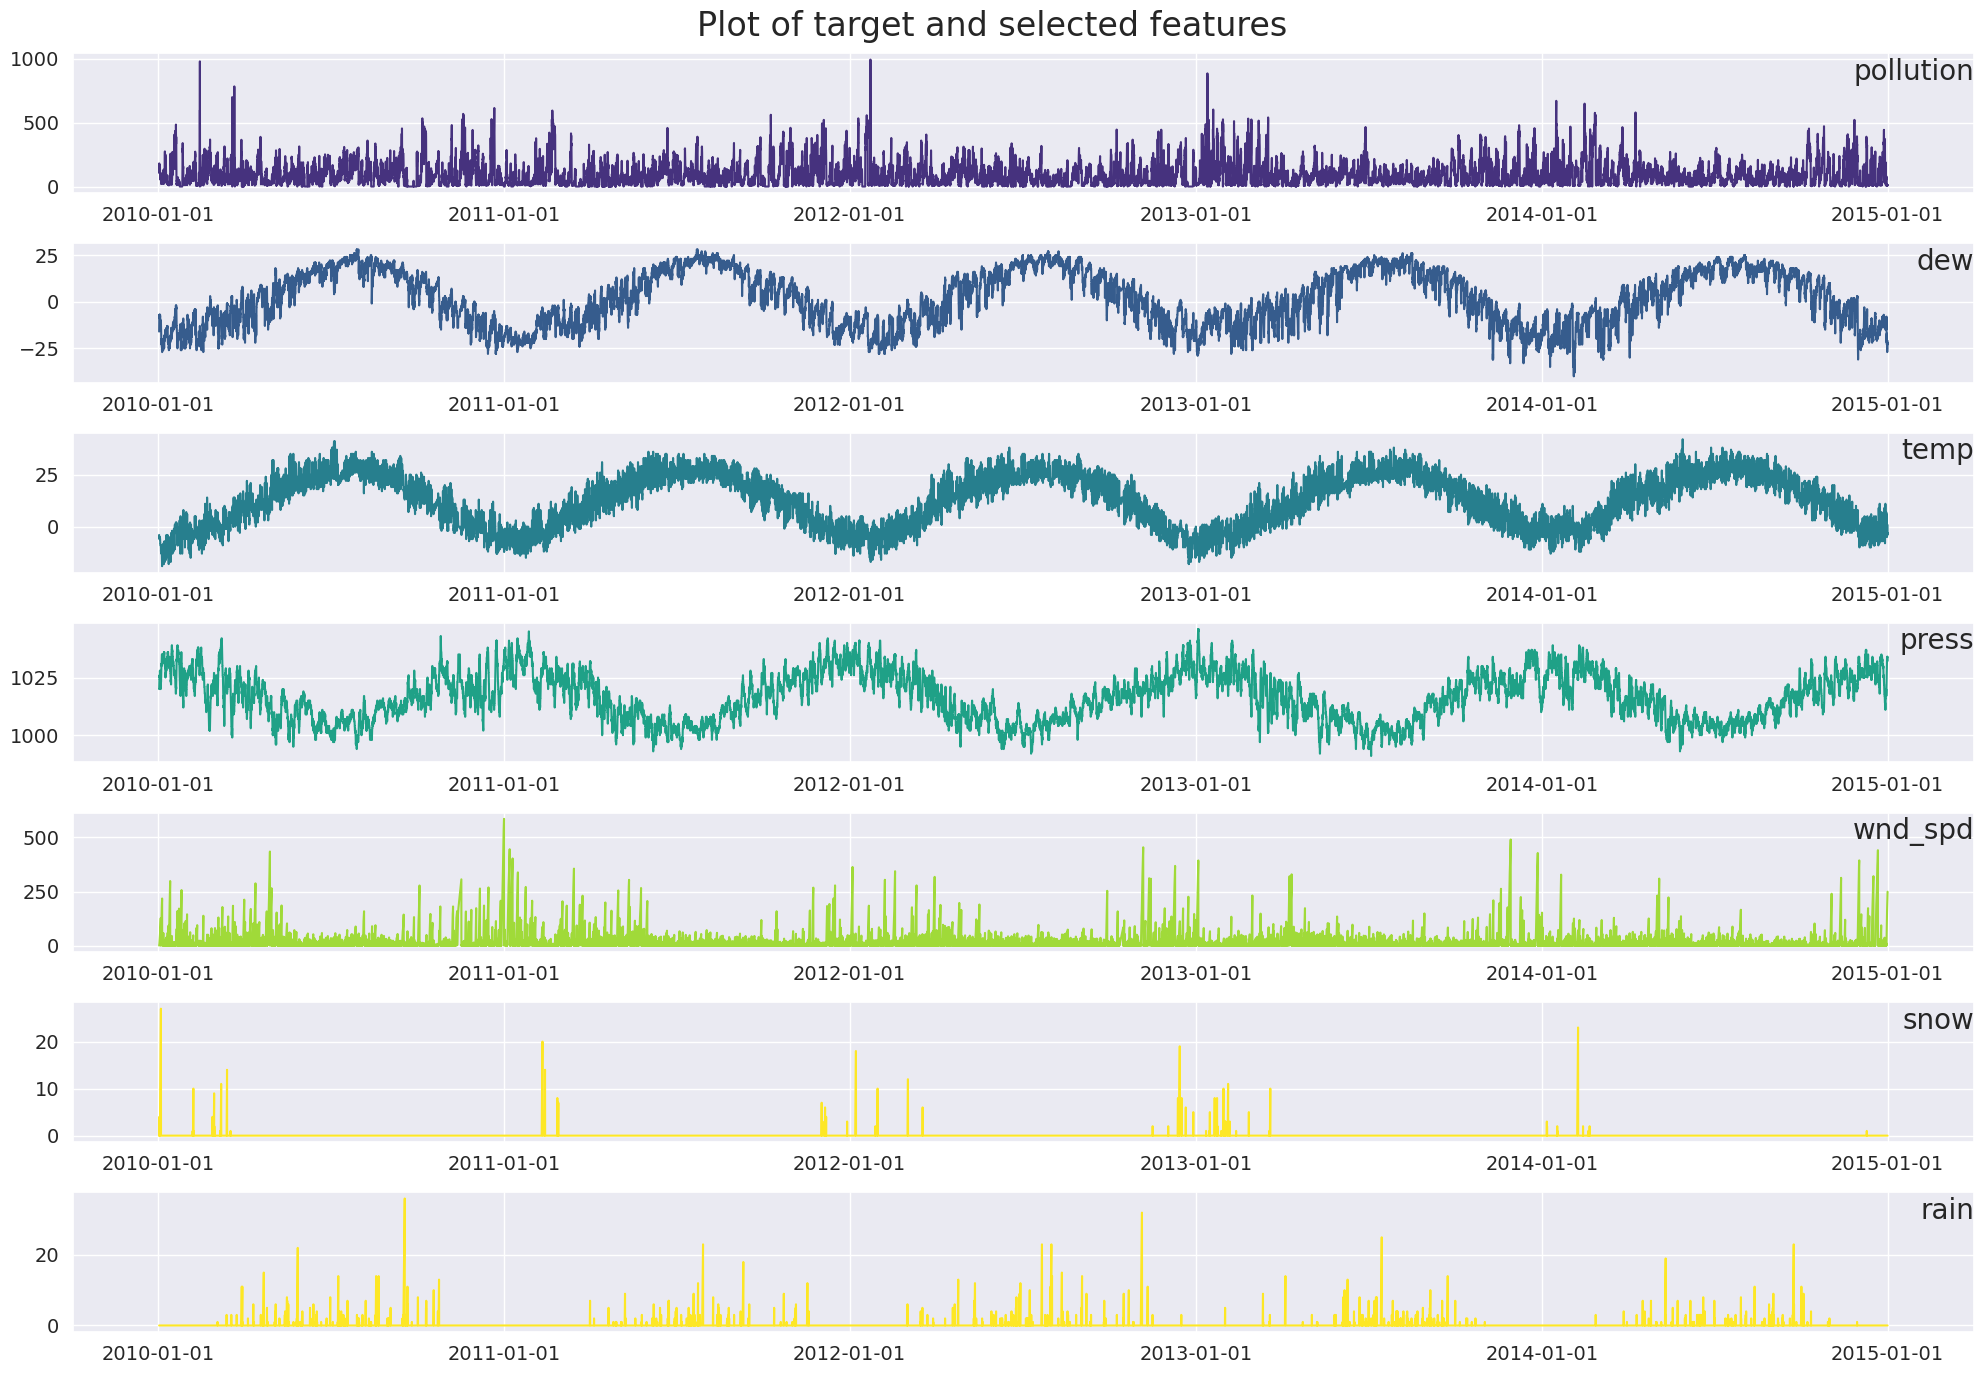

In [8]:
# Visualizing the numerical values
sn.set_theme(style="darkgrid")

values = pollution_df.values
dates = [datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S') for date_str in values[:,0]]

groups = [1, 2, 3, 4, 6, 7, 8]
i = 1

fig, axs = plt.subplots(len(groups), 1, figsize=(20, 14), facecolor='white')
for group, ax in zip(groups, axs):
    ax.plot(dates, values[:, group], color=cm.viridis(group/len(groups)))
    ax.set_title(pollution_df.columns[group], y=0.75, loc='right', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.grid(True)
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    i += 1

plt.suptitle('Plot of target and selected features', fontsize=24)
plt.tight_layout()
plt.show()

In [18]:
values[:,0]

array(['2010-01-02 00:00:00', '2010-01-02 01:00:00',
       '2010-01-02 02:00:00', ..., '2014-12-31 21:00:00',
       '2014-12-31 22:00:00', '2014-12-31 23:00:00'], dtype=object)

## Pytorch codes

### Custom dataset class

In [56]:
# Custom dataset class for pollution data
class PollutionData(Dataset):
    def __init__(self, X, y, seq_len, device=device):
        # Features and targets
        self.X = X
        self.y = y
        # Length of sequence
        self.seq_len = seq_len
        # Chosen device
        self.device = device

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Concatenate X and y to use target lags as input
        X_sample = np.concatenate([self.X, self.y], axis=1)
        
        # If the index is lower than sequence length, then apply padding
        # The data used for prediction should reach until 24h before the prediction
        # It will make more sense to be able to predict the pollution 24h from now than 1h from now
        if idx >= self.seq_len:
            X_sample = X_sample[(idx - self.seq_len):idx]      
        else:
            X_sample = X_sample[:idx]
            padding = np.zeros((self.seq_len - idx, X_sample.shape[1]))
            X_sample = np.concatenate([padding, X_sample], axis = 0)
        
        return torch.tensor(X_sample).to(torch.float32).to(self.device), torch.tensor(self.y[idx]).to(torch.float32).to(self.device)

### Lightning dataloader

In [57]:
# Custom lightning dataloader
class PollutionDataLoader(L.LightningDataModule):
    def __init__(self, train_dir, test_dir, seq_len, X_scaler, y_scaler, test_size, random_state, batch_size, num_workers, device):
        super().__init__()
        self.train_dir = train_dir
        self.test_dir = test_dir
        self.seq_len = seq_len
        self.X_scaler = X_scaler
        self.y_scaler = y_scaler
        self.test_size = test_size
        self.random_sate = random_state
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.device = device
        self.train_df = None
        self.test_df = None
        self.X_train = None
        self.y_train = None
        self.X_val = None
        self.y_val = None
        self.X_test = None
        self.y_test = None
        self.pollution_train = None
        self.pollution_val = None
        self.pollution_test = None

    def setup(self, stage):
        # Load the training dataset
        self.train_df = pd.read_csv(self.train_dir)
        # Load the test dataset
        self.test_df = pd.read_csv(self.test_dir)
        # Map the categories of wind direction to numeric values
        mapping = {"NE": 0, "NW": 1, "SE": 2, "cv": 3}
        self.train_df["wnd_dir"] = self.train_df.wnd_dir.map(mapping)
        self.test_df["wnd_dir"] = self.test_df.wnd_dir.map(mapping)
        # Create X and y by dropping date and seperating features and target
        X = self.train_df.drop(["date", "pollution"], axis=1)
        # Shift features by 24, because we want to predict pollution in 24h
        X = X.shift(periods=24, fill_value=0)
        y = self.train_df[["pollution"]]
        self.X_test = self.test_df.drop(["pollution"], axis=1)
        self.y_test = self.test_df[["pollution"]]
        # Apply train test split
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(X
                                                                              , y
                                                                              , test_size=self.test_size
                                                                              , shuffle=False
                                                                              , random_state=self.random_sate
                                                                              )
        
        # Transform with scaler if provided
        if self.X_scaler and self.y_scaler:
            self.X_train = self.X_scaler.fit_transform(self.X_train)
            self.X_val = self.X_scaler.transform(self.X_val)
            self.X_test = self.X_scaler.transform(self.X_test)
            self.y_train = self.y_scaler.fit_transform(self.y_train)
            self.y_val = self.y_scaler.transform(self.y_val)
            self.y_test = self.y_scaler.transform(self.y_test)

        # Create two instances of the custom dataset class
        self.pollution_train = PollutionData(self.X_train
                                             , self.y_train
                                             , seq_len=self.seq_len
                                             , device=self.device
                                             )
        self.pollution_val = PollutionData(self.X_val
                                           , self.y_val
                                           , seq_len=self.seq_len
                                           , device=self.device
                                             )
        self.pollution_test = PollutionData(self.X_test
                                            , self.y_test
                                            , seq_len=self.seq_len
                                            , device=self.device
                                            )

    def train_dataloader(self):
        # Return the dataloader of train data
        return DataLoader(self.pollution_train
                          , shuffle=True
                          , batch_size=self.batch_size
                          , drop_last=False
                          , num_workers=self.num_workers
                          )

    def val_dataloader(self):
        # Return the dataloader of validation data
        return DataLoader(self.pollution_val
                          , shuffle=False
                          , batch_size=self.batch_size
                          , drop_last=False
                          , num_workers=self.num_workers
                          )

    def test_dataloader(self):
        # Return the dataloader of test data
        return DataLoader(self.pollution_test
                          , shuffle=False
                          , batch_size=self.batch_size
                          , drop_last=False
                          , num_workers=self.num_workers
                          )

### LSTM model class

In [45]:
# LSTM model class
class LSTMModel(nn.Module):
    def __init__(self, in_size, h_size, num_l, out_f):
        super().__init__()
        self.input_size = in_size
        self.hidden_size = h_size
        self.num_layers = num_l
        self.out_features = out_f
        self.lstm = nn.LSTM(input_size=self.input_size
                            , hidden_size=self.hidden_size
                            , num_layers=self.num_layers
                            , batch_first=True
                            , dropout=0.1
                            )
        self.linear1 = nn.Linear(in_features=self.hidden_size
                                 , out_features=self.out_features)
    
    def forward(self, X):
        X, _ = self.lstm(X)
        X = self.linear1(X[:,-1,:])

        return X

### GRU model class

In [5]:
# GRU model class
class GRUModel(nn.Module):
    def __init__(self, in_size, h_size, num_l, out_f):
        super().__init__()
        self.input_size = in_size
        self.hidden_size = h_size
        self.num_layers = num_l
        self.out_features = out_f
        self.lstm = nn.GRU(input_size=self.input_size
                           , hidden_size=self.hidden_size
                           , num_layers=self.num_layers
                           , batch_first=True
                           , dropout=0.1
                           )
        self.linear1 = nn.Linear(in_features=self.hidden_size
                                 , out_features=self.out_features
                                 )
    
    def forward(self, X):
        X, _ = self.lstm(X)
        X = self.linear1(X[:,-1,:])

        return X

### Lightning time-series model class

In [77]:
# Time-series model created with lightning
class TSModel(L.LightningModule):
    def __init__(self, model, lr=0.01):
        super().__init__()
        # Model of choice (either LSTM or GRU)
        self.model = model
        # Learning rate
        self.lr = lr

    def training_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.model(X)
        train_loss = F.mse_loss(y_pred, y)
        self.log("train_loss", train_loss, prog_bar=True, on_step=False, on_epoch=True, sync_dist=True)
        return train_loss
    
    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.model(X)
        val_loss = F.mse_loss(y_pred, y)
        self.log("val_loss", val_loss, prog_bar=True, on_step=False, on_epoch=True, sync_dist=True)

    def test_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.model(X)
        test_loss = F.mse_loss(y_pred, y)
        self.log("test_loss", test_loss, sync_dist=True)
    
    def predict_step(self, batch, batch_id):
        X, y = batch
        y_pred = self.model(X)

        return y_pred

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

### Ray tuner

In [86]:
# Function for training with Ray tuner
def train_func(config):
    dm = PollutionDataLoader(train_dir="/home/maciej/Uni/Studia II stopień/II rok/Machine Learning 2/GRU-ML-presentation/data/LSTM-Multivariate_pollution.csv"
                             , test_dir="/home/maciej/Uni/Studia II stopień/II rok/Machine Learning 2/GRU-ML-presentation/data/pollution_test_data1.csv"
                             , seq_len=config["seq_len"]
                             , X_scaler=MinMaxScaler()
                             , y_scaler=MinMaxScaler()
                             , test_size=0.3
                             , random_state=42
                             , batch_size=config["batch_size"]
                             , num_workers=2
                             , device=device
                             )
    lstm_model = LSTMModel(in_size=8, h_size=config["h_size"], num_l=config["num_l"], out_f=1).to(device)
    model = TSModel(lstm_model, lr=config['lr'])

    trainer = L.Trainer(
        max_epochs=5,
        devices="auto",
        accelerator="auto",
        strategy=RayDDPStrategy(),
        callbacks=[RayTrainReportCallback()],
        plugins=[RayLightningEnvironment()],
        enable_progress_bar=True,
    )
    trainer = prepare_trainer(trainer)
    trainer.fit(model, datamodule=dm)

In [87]:
# The search space
search_space = {
    "seq_len": tune.choice([10])
    , "h_size": tune.choice([4, 8])
    , "num_l": tune.choice([4])
    , "lr": tune.choice([1e-4])
    , "batch_size": tune.choice([128])
}

In [92]:
# The maximum training epochs
num_epochs = 2

# Number of sampls from parameter space
num_samples = 2

In [93]:
scaling_config = ScalingConfig(
    num_workers=2, use_gpu=False
)

run_config = RunConfig(
    checkpoint_config=CheckpointConfig(
        num_to_keep=2,
        checkpoint_score_attribute="val_loss",
        checkpoint_score_order="min",
    ),
)

In [91]:
ray_trainer = TorchTrainer(
    train_func,
    scaling_config=scaling_config,
    run_config=run_config,
)

In [94]:
def tune_pollution_asha(num_samples=10):
    scheduler = ASHAScheduler(max_t=num_epochs, grace_period=1, reduction_factor=2)

    tuner = tune.Tuner(
        ray_trainer,
        param_space={"train_loop_config": search_space},
        tune_config=tune.TuneConfig(
            metric="val_loss",
            mode="min",
            num_samples=num_samples,
            scheduler=scheduler,
        ),
    )
    return tuner.fit()


results = tune_pollution_asha(num_samples=num_samples)

(TorchTrainer pid=65077) Starting distributed worker processes: ['65158 (192.168.1.17)', '65159 (192.168.1.17)']
(RayTrainWorker pid=65158) Setting up process group for: env:// [rank=0, world_size=2]
(TorchTrainer pid=65078) Starting distributed worker processes: ['65210 (192.168.1.17)', '65211 (192.168.1.17)']
(RayTrainWorker pid=65158) GPU available: False, used: False
(RayTrainWorker pid=65158) TPU available: False, using: 0 TPU cores
(RayTrainWorker pid=65158) IPU available: False, using: 0 IPUs
(RayTrainWorker pid=65158) HPU available: False, using: 0 HPUs
(RayTrainWorker pid=65210) Setting up process group for: env:// [rank=0, world_size=2]
(RayTrainWorker pid=65158) /home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosyste

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]


(RayTrainWorker pid=65210) GPU available: False, used: False
(RayTrainWorker pid=65210) TPU available: False, using: 0 TPU cores
(RayTrainWorker pid=65210) IPU available: False, using: 0 IPUs
(RayTrainWorker pid=65210) HPU available: False, using: 0 HPUs
(RayTrainWorker pid=65210) /home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  1.43it/s]
                                                                           
Epoch 0:   4%|▍         | 5/120 [00:02<00:57,  1.98it/s, v_num=0]
Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 0:   8%|▊         | 9/120 [00:03<00:39,  2.83it/s, v_num=0]
                                                                           
Epoch 0: 100%|██████████| 120/120 [00:44<00:00,  2.72it/s, v_num=0]
(RayTrainWorker pid=65158) 
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=65158) 
Validation DataLoader 0:   0%|          | 0/52 [00:00<?, ?it/s]
(RayTrainWorker pid=65158) 
Validation DataLoader 0:   2%|▏         | 1/52 [00:00<00:05,  9.20it/s]
(RayTrainWorker pid=65158) 
Validation DataLoader 0:   4%|▍         | 2/52 [00:00<00:06,  8.31it/s]
(RayTrainWorker pid=65158) 
Validation DataLoader 0:   6%|▌         | 3/52 [00:00<00:06,  7.09it/s]
(RayTrainWorker pid=65158) 
Validation DataLoader 0:   

(RayTrainWorker pid=65159) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/maciej/ray_results/TorchTrainer_2023-11-19_21-09-39/TorchTrainer_91ea7_00000_0_batch_size=128,h_size=4,lr=0.0001,num_l=4,seq_len=10_2023-11-19_21-09-39/checkpoint_000000)
(RayTrainWorker pid=65210) Missing logger folder: /home/maciej/ray_results/TorchTrainer_2023-11-19_21-09-39/TorchTrainer_91ea7_00001_1_batch_size=128,h_size=4,lr=0.0001,num_l=4,seq_len=10_2023-11-19_21-09-39/lightning_logs [repeated 3x across cluster]
(RayTrainWorker pid=65210) 
(RayTrainWorker pid=65210)   | Name  | Type      | Params
(RayTrainWorker pid=65210) ------------------------------------ [repeated 2x across cluster]
(RayTrainWorker pid=65210) 0 | model | LSTMModel | 709   
(RayTrainWorker pid=65210) 709       Trainable params
(RayTrainWorker pid=65210) 0         Non-trainable params
(RayTrainWorker pid=65210) 709       Total params
(RayTrainWorker pid=65210) 0.003     Total estimated model params size (MB)

Epoch 0: 100%|██████████| 120/120 [00:54<00:00,  2.19it/s, v_num=0, val_loss=0.057, train_loss=0.066]
(RayTrainWorker pid=65210)  [repeated 38x across cluster]
Epoch 1:   3%|▎         | 4/120 [00:04<02:23,  0.81it/s, v_num=0, val_loss=0.057, train_loss=0.066]
(RayTrainWorker pid=65210)  [repeated 13x across cluster]
Epoch 1:   8%|▊         | 10/120 [00:07<01:25,  1.28it/s, v_num=0, val_loss=0.057, train_loss=0.066]


(RayTrainWorker pid=65210) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/maciej/ray_results/TorchTrainer_2023-11-19_21-09-39/TorchTrainer_91ea7_00001_1_batch_size=128,h_size=4,lr=0.0001,num_l=4,seq_len=10_2023-11-19_21-09-39/checkpoint_000000) [repeated 2x across cluster]


Epoch 1:  12%|█▏        | 14/120 [00:10<01:16,  1.39it/s, v_num=0, val_loss=0.057, train_loss=0.066]
(RayTrainWorker pid=65210)  [repeated 10x across cluster]
Epoch 1: 100%|██████████| 120/120 [01:15<00:00,  1.59it/s, v_num=0, val_loss=0.057, train_loss=0.066]
(RayTrainWorker pid=65158) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1:  91%|█████████ | 109/120 [01:07<00:06,  1.61it/s, v_num=0, val_loss=0.00903, train_loss=0.0112] [repeated 8x across cluster]
(RayTrainWorker pid=65158) 
Epoch 1:  93%|█████████▎| 112/120 [01:09<00:04,  1.62it/s, v_num=0, val_loss=0.00903, train_loss=0.0112]
(RayTrainWorker pid=65158) 
Validation DataLoader 0:   2%|▏         | 1/52 [00:00<00:14,  3.55it/s]
(RayTrainWorker pid=65158) 
Validation DataLoader 0:   4%|▍         | 2/52 [00:00<00:11,  4.19it/s]
(RayTrainWorker pid=65158) 
Validation DataLoader 0:   6%|▌         | 3/52 [00:00<00:14,  3.40it/s]
(RayTrainWorker pid=65158) 
Validation DataLoader 0:   8%|▊         | 4/52 [00:01<00:18,  2.62it/s

(RayTrainWorker pid=65158) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/maciej/ray_results/TorchTrainer_2023-11-19_21-09-39/TorchTrainer_91ea7_00000_0_batch_size=128,h_size=4,lr=0.0001,num_l=4,seq_len=10_2023-11-19_21-09-39/checkpoint_000001) [repeated 2x across cluster]


Validation DataLoader 0:  69%|██████▉   | 36/52 [00:10<00:04,  3.55it/s] [repeated 36x across cluster]


2023-11-19 21:13:06,399	INFO tune.py:1047 -- Total run time: 206.70 seconds (206.67 seconds for the tuning loop).


(RayTrainWorker pid=65210) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/maciej/ray_results/TorchTrainer_2023-11-19_21-09-39/TorchTrainer_91ea7_00001_1_batch_size=128,h_size=4,lr=0.0001,num_l=4,seq_len=10_2023-11-19_21-09-39/checkpoint_000001)


Epoch 1:   0%|          | 0/120 [00:00<?, ?it/s, v_num=0, val_loss=0.00816, train_loss=0.00935]          


In [97]:
results.get_best_result(metric="val_loss", mode="min")

Result(
  metrics={'val_loss': 0.008156120777130127, 'train_loss': 0.009347268380224705, 'epoch': 1, 'step': 240},
  path='/home/maciej/ray_results/TorchTrainer_2023-11-19_21-09-39/TorchTrainer_91ea7_00001_1_batch_size=128,h_size=4,lr=0.0001,num_l=4,seq_len=10_2023-11-19_21-09-39',
  filesystem='local',
  checkpoint=Checkpoint(filesystem=local, path=/home/maciej/ray_results/TorchTrainer_2023-11-19_21-09-39/TorchTrainer_91ea7_00001_1_batch_size=128,h_size=4,lr=0.0001,num_l=4,seq_len=10_2023-11-19_21-09-39/checkpoint_000001)
)

### Training loop

In [58]:
# Creating the lightning data loader
pollution_loader = PollutionDataLoader(train_dir="data/LSTM-Multivariate_pollution.csv"
                                       , test_dir="data/pollution_test_data1.csv"
                                       , seq_len=10
                                       , X_scaler=MinMaxScaler()
                                       , y_scaler=MinMaxScaler()
                                       , test_size=0.3
                                       , random_state=42
                                       , batch_size=128
                                       , num_workers=7
                                       , device=device
                                       )

#### LSTM

In [12]:
lstm_model = LSTMModel(in_size=8, h_size=8, num_l=4, out_f=1).to(device)
lstm_ts_model = TSModel(lstm_model)

lstm_trainer = L.Trainer(max_epochs=2, enable_checkpointing=False)
lstm_trainer.fit(lstm_ts_model, datamodule=pollution_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



  | Name  | Type      | Params
------------------------------------
0 | model | LSTMModel | 2.3 K 
------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


In [9]:
lstm_trainer.test(lstm_ts_model, dataloaders=pollution_loader.test_dataloader())

Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.0008601871668361127
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.0008601871668361127}]

In [13]:
lstm_preds = lstm_trainer.predict(lstm_ts_model, dataloaders=pollution_loader.test_dataloader())

Predicting: |          | 0/? [00:00<?, ?it/s]

In [14]:
lstm_preds

[tensor([[0.0688],
         [0.0973],
         [0.1140],
         [0.1062],
         [0.1029],
         [0.1024],
         [0.1014],
         [0.1542],
         [0.2255],
         [0.2484],
         [0.2070],
         [0.1640],
         [0.1502],
         [0.1515],
         [0.1493],
         [0.1354],
         [0.1272],
         [0.1312],
         [0.1424],
         [0.1418],
         [0.1351],
         [0.1210],
         [0.1184],
         [0.1186],
         [0.1268],
         [0.1414],
         [0.1617],
         [0.1735],
         [0.1950],
         [0.2153],
         [0.2370],
         [0.2527],
         [0.2388],
         [0.2368],
         [0.2485],
         [0.2609],
         [0.2529],
         [0.2389],
         [0.2139],
         [0.1908],
         [0.1866],
         [0.1946],
         [0.1289],
         [0.0746],
         [0.0506],
         [0.0424],
         [0.0391],
         [0.0378],
         [0.0371],
         [0.0364],
         [0.0355],
         [0.0338],
         [0.

#### GRU

In [ ]:
gru_model = LSTMModel(in_size=8, h_size=8, num_l=4, out_f=1).to(device)
gru_ts_model = TSModel(lstm_model)

gru_trainer = L.Trainer(max_epochs=3, enable_checkpointing=False)
gru_trainer.fit(gru_ts_model, pollution_loader.train_dataloader, pollution_loader.val_dataloader)

#### Functions

In [17]:
# Plot the loss curve
def plot_loss_curve(train_loss_list, val_loss_list, n_epochs):
    x_range = range(1, n_epochs+1)

    plt.plot(x_range, train_loss_list)
    plt.plot(x_range, val_loss_list)
    plt.title("Loss curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss metric")
    plt.xticks(x_range)
    plt.show()


# Predicting on new data
def predict_model(model, data_loader):
    model.eval()
    output = torch.tensor([])

    with torch.no_grad():
        for X, _ in data_loader:
            y_pred = model(X)
            output = torch.cat((output, y_pred), 0)
    
    return output.cpu().numpy()